<a id = "1"></a>
# 1. Import Libraries and Check Data 🧐

In [2]:
# Basic Libraries 📚
# --------------------------------------
import numpy as np
import pandas as pd


# Plot library 📊
# --------------------------------------
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.io as pio


# NLP
# --------------------------------------
import nltk
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import Word, TextBlob
from wordcloud import WordCloud  # visualization of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer


# Metrics 📐
# --------------------------------------
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate
from sklearn.preprocessing import LabelEncoder


# Machine Learning Models 🤖
# --------------------------------------
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


# Customize to Remove Warnings and Better Observation 🔧
# --------------------------------------------------------
from warnings import filterwarnings
filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [3]:
df = pd.read_excel("../input/amazon-reviews/amazon.xlsx")
df.head()

Star  HelpFul                                          Title                                             Review
0     5        0                                    looks great                                      Happy with it
1     5        0  Pattern did not align between the two panels.  Good quality material however the panels are m...
2     5        0               Imagery is stretched. Still fun.  Product was fun for bedroom windows.<br />Imag...
3     5        0                 Que se ven elegantes muy finas   Lo unico que me gustaria es que sean un poco ...
4     5        0                             Wow great purchase  Great bang for the buck I can't believe the qu...

In [4]:
df.isnull().sum()

Star        0
HelpFul     0
Title      52
Review     18
dtype: int64

Just drop the missing values without deep analysis for process.

In [5]:
df.dropna(subset=['Review'], inplace=True)
df.isnull().sum()

Star        0
HelpFul     0
Title      43
Review      0
dtype: int64


# 2. Text Preprocessing


In [6]:
# to put all the characters in a standard
df['Review'] = df['Review'].str.lower()  # make all lowercase

---

In [7]:
# check sentences and replace punctions with spaces
df['Review'] = df['Review'].str.replace('[^\w\s]', '')

In [8]:
df['Review'] = df['Review'].str.replace('\d', '')  

In [9]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [10]:
# save the downloaded stopwords
sw = stopwords.words('english')

In [11]:
df['Review'] = df['Review'].apply(lambda x: " ".join(x for x in str(x).split() if x not in sw))

In [12]:
# to find how many times words counts
temp_df = pd.Series(' '.join(df['Review']).split()).value_counts()
temp_df

curtains          1891
love              1312
room              1116
like              1037
beautiful          943
                  ... 
mold                 1
wat                  1
curtainsdrapes       1
ambesome             1
studioliving         1
Length: 6698, dtype: int64

In [13]:
# choose the words with less than 2 frequencies to drop
drops = temp_df[temp_df <= 1]

The process is similar to Stopwords section. Look the "Review" column, split the reviews, then, join the words that are not in **drops**.

In [14]:
df['Review'] = df['Review'].apply(lambda x: " ".join(x for x in x.split() if x not in drops))

In [15]:
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


True

In [16]:
df['Review'] = df['Review'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))


# 3. Visualization

In [17]:
# extract the term frequencies(frequency of the words) and create a df
tf = df["Review"].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()
tf.head()

index      0
0     happy 196.00
1      good 535.00
2   quality 889.00
3  material 565.00
4   however  78.00

In [18]:
# fix the column names
tf.columns = ["words", "tf"]  

In [19]:
# to see the most frequent words
tf.sort_values("tf", ascending=False)

words      tf
58     curtain 2588.00
35        look 1531.00
108       love 1453.00
92        room 1129.00
152       like 1053.00
...        ...     ...
1940      nail    2.00
1941     salon    2.00
1944     write    2.00
1947  colorsbr    2.00
2726     miran    2.00

[2727 rows x 2 columns]

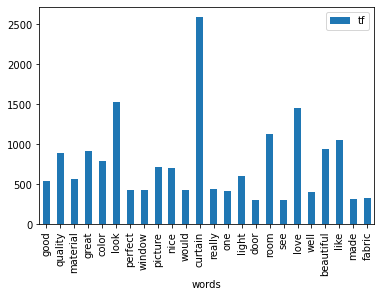

In [20]:
tf[tf["tf"] > 300].plot.bar(x="words", y="tf")
plt.show()

In [21]:
# check every row and join with these with a space
text = " ".join(i for i in df.Review) 

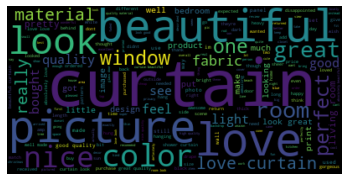

In [22]:
wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

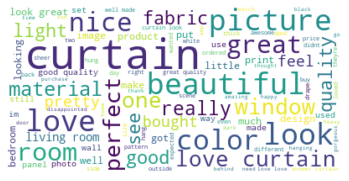

In [23]:
# configure the graph
wordcloud = WordCloud(max_font_size=50,
                      max_words=100,
                      background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


# 4. Sentiment Analysis 😍😕


In [24]:
df["Review"].head()

0                                                happy
1                  good quality material however panel
2    product fun bedroom windowsbr imagery bit stre...
3                              lo que e que un poco ma
4    great bang buck cant believe quality material ...
Name: Review, dtype: object

In [25]:
nltk.download('vader_lexicon')  # pre-trained model for sentiment analysis

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [26]:
# Example 1
sia = SentimentIntensityAnalyzer()
sia.polarity_scores("The film was awesome")

{'neg': 0.0, 'neu': 0.423, 'pos': 0.577, 'compound': 0.6249}

In [27]:
# Example 2
sia.polarity_scores("I liked this music but it is not good as the other one")

{'neg': 0.207, 'neu': 0.666, 'pos': 0.127, 'compound': -0.298}

In [28]:
df["Review"][0:10].apply(lambda x: sia.polarity_scores(x)) 

0    {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound...
1    {'neg': 0.0, 'neu': 0.58, 'pos': 0.42, 'compou...
2    {'neg': 0.0, 'neu': 0.625, 'pos': 0.375, 'comp...
3    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
4    {'neg': 0.0, 'neu': 0.495, 'pos': 0.505, 'comp...
5    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
6    {'neg': 0.0, 'neu': 0.594, 'pos': 0.406, 'comp...
7    {'neg': 0.0, 'neu': 0.578, 'pos': 0.422, 'comp...
8    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
9    {'neg': 0.0, 'neu': 0.772, 'pos': 0.228, 'comp...
Name: Review, dtype: object

In [29]:
# take only compound scores
df["Review"][0:10].apply(lambda x: sia.polarity_scores(x)["compound"]) 

0   0.57
1   0.44
2   0.72
3   0.00
4   0.90
5   0.00
6   0.62
7   0.91
8   0.00
9   0.71
Name: Review, dtype: float64

In [30]:
# save the scores as a new column
df["polarity_score"] = df["Review"].apply(lambda x: sia.polarity_scores(x)["compound"])


# 5. Feature Engineering

In [31]:
# we have such values and we will create a new variable by taking all of them so that we have a label.
df["Review"][0:10].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")

0    pos
1    pos
2    pos
3    neg
4    pos
5    neg
6    pos
7    pos
8    neg
9    pos
Name: Review, dtype: object

In [32]:
# if we want to see this example with new label and pos/neg side by side
rev_pol = pd.concat([df["Review"][0:10], df["Review"][0:10].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")], axis=1)
rev_pol.columns = ["Review", "Polarity Scores"]
rev_pol

Review Polarity Scores
0                                              happy             pos
1                good quality material however panel             pos
2  product fun bedroom windowsbr imagery bit stre...             pos
3                            lo que e que un poco ma             neg
4  great bang buck cant believe quality material ...             pos
5                               look different photo             neg
6    exactly looking heavy material great price fast             pos
7  looking picture thought curtain would thinner ...             pos
8  much thought would wasnt really expecting want...             neg
9  curtain picture show rd set ambesonne curtain ...             pos

> **Let's assign a new variable with a polarity score greater than 0 to be positive and the smaller ones to be negative.**

In [33]:
df["sentiment_label"] = df["Review"].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")
df["sentiment_label"].value_counts()

pos    4764
neg     829
Name: sentiment_label, dtype: int64

> **Let's look at the averages of scores of positive/negative comments.**

In [34]:
df.groupby("sentiment_label")["Star"].mean()

sentiment_label
neg   3.40
pos   4.58
Name: Star, dtype: float64

<span style="color:#008000"><b>It seems logical and we are on the right road! 🥳</b></span>

> **Our label has a string naming as pos/neg which is not binary encoded, let's pass it through label_encoder.**

In [35]:
df["sentiment_label"] = LabelEncoder().fit_transform(df["sentiment_label"])

In [36]:
y = df["sentiment_label"]
X = df["Review"]

In [37]:
print(" X ".center(50, "~"))
display(X.head())
print("")
print(" Y ".center(50, "~"))
display(y.head())

~~~~~~~~~~~~~~~~~~~~~~~ X ~~~~~~~~~~~~~~~~~~~~~~~~


0                                                happy
1                  good quality material however panel
2    product fun bedroom windowsbr imagery bit stre...
3                              lo que e que un poco ma
4    great bang buck cant believe quality material ...
Name: Review, dtype: object


~~~~~~~~~~~~~~~~~~~~~~~ Y ~~~~~~~~~~~~~~~~~~~~~~~~


0    1
1    1
2    1
3    0
4    1
Name: sentiment_label, dtype: int64

In [38]:
a = """ngram is a contiguous sequence of n items from a given sample of text or speech."""

TextBlob(a).ngrams(3)  # For example, let's create a triple ngram

[WordList(['ngram', 'is', 'a']),
 WordList(['is', 'a', 'contiguous']),
 WordList(['a', 'contiguous', 'sequence']),
 WordList(['contiguous', 'sequence', 'of']),
 WordList(['sequence', 'of', 'n']),
 WordList(['of', 'n', 'items']),
 WordList(['n', 'items', 'from']),
 WordList(['items', 'from', 'a']),
 WordList(['from', 'a', 'given']),
 WordList(['a', 'given', 'sample']),
 WordList(['given', 'sample', 'of']),
 WordList(['sample', 'of', 'text']),
 WordList(['of', 'text', 'or']),
 WordList(['text', 'or', 'speech'])]

In [39]:
corpus = ['This is the first document.',
          'This document is the second document.',
          'And this is the third one.',
          'Is this the first document?']

In [40]:
# word frequency
vectorizer = CountVectorizer()
X_c = vectorizer.fit_transform(corpus)  # we transformed the corpus with fit_transform
vectorizer.get_feature_names()  

['and', 'document', 'first', 'is', 'one', 'second', 'the', 'third', 'this']

> **We extract unique words (ie we thought the whole text as a single text and brought the unique words) => ['and', 'document', 'first', 'is', 'one', 'second', 'the', 'third' ', 'this']**

In [41]:
X_c.toarray()  # we vectorized each unit

array([[0, 1, 1, 1, 0, 0, 1, 0, 1],
       [0, 2, 0, 1, 0, 1, 1, 0, 1],
       [1, 0, 0, 1, 1, 0, 1, 1, 1],
       [0, 1, 1, 1, 0, 0, 1, 0, 1]])

It means:
* First document includes 0 "and", 1 "document", 1 "first" etc.
* Second document includes 0 "and", 2 "document", 0 "first" etc.
* Third document includes 1 "and", 0 "document", 0 "first" etc.
* Fourth document includes 0 "and", 1 "document", 1 "first" etc.
---

For ngram, we will use an argument as **analyzer="word"**, if we do not enter any argument, the default of CountVectorizer is to make *word frequency*.

In [42]:
# n-gram
vectorizer2 = CountVectorizer(analyzer='word', ngram_range=(2, 2))
X_n = vectorizer2.fit_transform(corpus)
vectorizer2.get_feature_names()  # it brought the words one by one above, now he brought them in phrases

['and this',
 'document is',
 'first document',
 'is the',
 'is this',
 'second document',
 'the first',
 'the second',
 'the third',
 'third one',
 'this document',
 'this is',
 'this the']

In [43]:
X_n.toarray()

array([[0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0],
       [0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0],
       [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0],
       [0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1]])

In [44]:
vectorizer = CountVectorizer()  # default => word count
X_count = vectorizer.fit_transform(X)  # X stands for texts, we only count the frequencies of the words

In [45]:
vectorizer.get_feature_names()[10:15]  # let's look at some features

['accessory', 'accommodate', 'account', 'accurate', 'across']

In [46]:
X_count.toarray()[10:15]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

> **Let's keep this aside, let's produce features according to other methods. For example, let's look at the TF-IDF method, derive features according to both word frequencies and ngrams, then compare the frequencies of these 3 methods in machine learning.**

In [47]:
# word frequency
tf_idf_word_vectorizer = TfidfVectorizer()  # default = word frequency
corpus_tf_idf_word = tf_idf_word_vectorizer.fit_transform(corpus)
tf_idf_word_vectorizer.get_feature_names_out()

array(['and', 'document', 'first', 'is', 'one', 'second', 'the', 'third',
       'this'], dtype=object)

In [48]:
corpus_tf_idf_word.toarray()

array([[0.        , 0.46979139, 0.58028582, 0.38408524, 0.        ,
        0.        , 0.38408524, 0.        , 0.38408524],
       [0.        , 0.6876236 , 0.        , 0.28108867, 0.        ,
        0.53864762, 0.28108867, 0.        , 0.28108867],
       [0.51184851, 0.        , 0.        , 0.26710379, 0.51184851,
        0.        , 0.26710379, 0.51184851, 0.26710379],
       [0.        , 0.46979139, 0.58028582, 0.38408524, 0.        ,
        0.        , 0.38408524, 0.        , 0.38408524]])

> **Same with Count Vectors, each text on corpus were taken and each words' TF-IDF scores were calculated above according to word frequency.**

In [49]:
# ngram
tf_idf_ngram_vectorizer = TfidfVectorizer(ngram_range=(2, 3))
corpus_tf_idf_ngram = tf_idf_ngram_vectorizer.fit_transform(X)
tf_idf_ngram_vectorizer.get_feature_names_out()

array(['ability privacy', 'ability privacy apartment', 'ability return',
       ..., 'zoomed set curtain', 'zoomed thats', 'zoomed thats probably'],
      dtype=object)

In [50]:
corpus_tf_idf_ngram.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

> **Above, we can see the TF-IDF scores to ngrams.**

In [51]:
# word
tf_idf_word_vectorizer = TfidfVectorizer()
X_tf_idf_word = tf_idf_word_vectorizer.fit_transform(X)

In [52]:
# ngram
tf_idf_ngram_vectorizer = TfidfVectorizer(ngram_range=(2, 3))
X_tf_idf_ngram = tf_idf_ngram_vectorizer.fit_transform(X)


# 6. Sentiment Modeling

In [53]:
# Words with TF-IDF
log_model = LogisticRegression().fit(X_tf_idf_word, y)
cross_val_score(log_model,
                X_tf_idf_word,
                y,
                scoring="accuracy",
                cv=5).mean()

0.8937963713448468

> **Let's predict if a new review comes out.**

In [54]:
# get a new comment
new_review = pd.Series("this product is great")

> **We vectorized the words in the process, we can also vectorize the words of the new review and ask the model to predict.**

In [55]:
# vectorize the new review
new_review = TfidfVectorizer().fit(X).transform(new_review)

# predict the sentiment of review
log_model.predict(new_review)

array([1])

> **1 means positive review, 0 means negative reviews.**

In [56]:
# Let's pick a sample comment from the original dataset and ask it to the model
sample = df["Review"].sample(1).values
print(sample)
random_review = pd.Series(sample)
new_review = TfidfVectorizer().fit(X).transform(random_review)
log_model.predict(new_review)

['muy la tela son muy de se la']


array([0])

In [57]:
# Count Vectors
rf_model = RandomForestClassifier().fit(X_count, y)
print("Count Vectors Score", cross_val_score(rf_model, X_count, y, cv=5, n_jobs=-1).mean()) 

# TF-IDF Word-Level
rf_model = RandomForestClassifier().fit(X_tf_idf_word, y)
print("TF-IDF Word-Level Score", cross_val_score(rf_model, X_tf_idf_word, y, cv=5, n_jobs=-1).mean())

# TF-IDF N-Gram
rf_model = RandomForestClassifier().fit(X_tf_idf_ngram, y)
print("TF-IDF N-Gram Score", cross_val_score(rf_model, X_tf_idf_ngram, y, cv=5, n_jobs=-1).mean())

Count Vectors Score 0.924368166696242
TF-IDF Word-Level Score 0.9170384367591176
TF-IDF N-Gram Score 0.8567849840373064


> **Let's plot these scores.**

In [58]:
%%time
def score(method_list):
    scores = []
    for method in method_list:
        rf_model = RandomForestClassifier().fit(method, y)
        scores.append(cross_val_score(rf_model, method, y, cv=5, n_jobs=-1).mean())
        
    scores_df = pd.DataFrame({"Methods": ["Count Vectors", "TF-IDF Word-Level", "TF-IDF N-Gram"],
                             "Scores": scores})
    
    trace1 = go.Bar(
                    y = scores_df["Methods"],
                    x = scores_df["Scores"],
                    name = "Accuracy Plot",
                    text=[round(i,5) for i in scores_df['Scores']],
                    marker = dict(color = ['#2ECC71','#34495E','#D0D3D4'],
                                 line=dict(color='rgb(0,0,0)',width=1.5)),
        orientation='h', textposition = 'inside'
    )
    data = [trace1]
    layout = go.Layout(barmode = "group", 
                       title={'text': "Scores" ,
                                 'y':0.9,
                                 'x':0.5,
                                 'xanchor': 'center',
                                 'yanchor': 'top'},
                          template='plotly_white')
    fig = go.Figure(data = data, layout = layout)
    pio.show(fig)
    
method_list = [X_count, X_tf_idf_word, X_tf_idf_ngram]
score(method_list)

CPU times: user 16 s, sys: 283 ms, total: 16.3 s
Wall time: 2min 53s


In [59]:
rf_model = RandomForestClassifier(random_state=17)  # create an empty model object

We apply GridSearchCV with a small number of parameter values in order not to prolong the process. More parameters and more values can be experimented with, this will increase the processing time so we give a brief overview here.

In [60]:
%%time
rf_params = {"max_depth": [8, None],
             "max_features": [7, "auto"],
             "min_samples_split": [2, 5, 8],
             "n_estimators": [100, 200]
             }

rf_best_grid = GridSearchCV(rf_model,
                            rf_params,
                            cv=5,
                            n_jobs=-1,
                            verbose=1).fit(X_count, y)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [61]:
# best parameters that GridSearchCV found
rf_best_grid.best_params_

{'max_depth': None,
 'max_features': 'auto',
 'min_samples_split': 2,
 'n_estimators': 100}

In [62]:
# set the model with the parameters GridSearchCV found above
rf_final = rf_model.set_params(**rf_best_grid.best_params_, random_state=17).fit(X_count, y)

# our final score
cross_val_score(rf_final, X_count, y, cv=5, n_jobs=-1).mean()

0.9250846894029138